In [1]:
import numpy as np
import matplotlib.pyplot as plt

### testing

In [2]:
img = np.array([
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
])

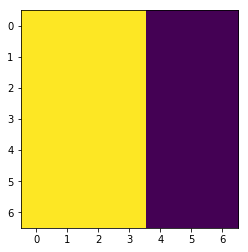

In [3]:
plt.imshow(img)

In [4]:
W = np.array([
    [1, 0, -1], 
    [1, 0, -1], 
    [1, 0, -1]
])

In [5]:
n = img.shape[0]
f = W.shape[0]
p = 0
s = 1
a = int((n+2*p-f)/s)+1

In [6]:
y = np.zeros((a,a))

In [7]:
for i in range(a):
    for j in range(a):
        y[i, j] = np.sum((img[i:i+f,j:j+f]*W))

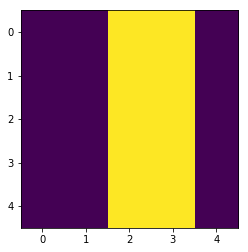

In [8]:
plt.imshow(y)

### Extending to full layer with multiple channels and training examples 

Defining an input

In [9]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 3

In [10]:
A_0 = np.random.rand(m, nh_0, nw_0, nc_0)
#A_0 = np.expand_dims(A_0,axis=len(A_0.shape))

Defining layer parameters

In [11]:
from meik.utils.activations import relu, drelu

In [12]:
f_1 = 5
nc_1 = 10
s_1 = 1
p_1 = 0
g_1 = relu
dg_1 = drelu

In [13]:
nh_1 = int((nh_0+2*p_1-f_1)/s_1)+1
nw_1 = int((nw_0+2*p_1-f_1)/s_1)+1

Defining layer variables

In [14]:
W_1 = np.random.rand(f_1, f_1, nc_0, nc_1)

In [15]:
b_1 = np.random.rand(1, 1, 1, nc_1)

In [16]:
Z_1 = np.zeros((m,nh_1,nw_1,nc_1))

Computing forwardprop

In [17]:
for i in range(nh_1):
    for j in range(nw_1):
        axes = tuple(i for i in range(1,len(Z_1.shape)))
        # Note on np.newaxis: extension of A dimension such that it is copied along the additional axis for multiplication
        Z_1[:, i, j, :] = np.sum((A_0[:,i:i+f_1,j:j+f_1,:,np.newaxis]*W_1), axis=axes) + b_1
A_1 = g_1(Z_1)

### Computing backprop

In [18]:
dA_1 = np.random.random(A_1.shape)

In [19]:
dZ_1 = dg_1(A_1)*dA_1

In [20]:
axes = tuple(i for i in range(0,len(dA_1.shape)-1))
db_1 = np.sum(dZ_1, axis=axes, keepdims=True)

In [21]:
#For 2D input, single example, single filter

A = A_0[0,:,:,0]
W = W_1[:,:,0,0]
dZ = dZ_1[0,:,:,0]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):

            dW += A[i:i+f_1,j:j+f_1]*dZ[i,j]
            
            dA[i:i+f_1,j:j+f_1] += dZ[i,j]*W

In [22]:
#For ND input, single example, single filter

A = A_0[0,:,:,:]
W = W_1[:,:,:,0]
dZ = dZ_1[0,:,:,0]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):
    
            dW += A[i:i+f_1,j:j+f_1,:]*dZ[i,j]
            
            dA[i:i+f_1,j:j+f_1,:] += dZ[i,j]*W

In [23]:
#For ND input, single example, multiple filters

A = A_0[0,:,:,:] 
W = W_1[:,:,:,:]
dZ = dZ_1[0,:,:,:]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):
    
            dW += A[i:i+f_1,j:j+f_1,:,np.newaxis]*dZ[i,j,:]
            
            dA[i:i+f_1,j:j+f_1,:] += np.sum(W*dZ[i,j,:], axis=3, keepdims=False) #summing across layer 1 filters

In [24]:
#For ND input, multiple examples, multiple filter

A = A_0[:,:,:,:] 
W = W_1[:,:,:,:]
dZ = dZ_1[:,:,:,:]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):
        
            A_ = A[:,i:i+f_1,j:j+f_1,:,np.newaxis]
            dZ_ = dZ[:,i,j,:][:,np.newaxis,np.newaxis,np.newaxis,:] 
            
            dW += np.sum(A_*dZ_, axis=0, keepdims=False)
            
            W_ = W[np.newaxis]
            
            dA[:,i:i+f_1,j:j+f_1,:] += np.sum(W_*dZ_, axis=4, keepdims=False)

### Gradient checking backprop

TO DO: gradient check of backprop 

    i) calculate dA_1/dW_1 and dA_1/dA_0 numerically
    ii) set dL/dA_1 as something random
    iii) thus obtain dL/dW_1 = dL/dA_1*dA_1/dW_1 etc. numerically
    iv) calculate dL/dW_1 = d and dL/dA_0 analytically using backprop and the arbitrary dL/dA_1
    v) calculate distance
    
Hopefully no debugging needed :P